In [33]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words = stopwords.words('russian')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come',
                  'в', 'на', 'www', 'а', 'за', 'но', 'это', 'http', 'https', 'com', 'youtube', 'v', 'wy', 'и', 'у',
                  'если', 'аж', 'чем', 'было', 'очень', 'почти', 'можно', 'после', 'об', 'о', 'этом', 'саит', 'сайт', 
                    'часто', 'мы', 'я', 'вы', 'они', 'tv', 'ru', 'стать', 'месяц', 'мочь', 'хотеть', 'весь', 'сеичас',
                   'сейчас', 'наш', 'самыи', 'минута', 'такои', 'рассказать', 'io', 'thebell', 'the', 'посмотреть',
                  'чтомнесэтыи', 'сообщать'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [24]:
# Import Dataset
df = pd.read_json('data/history/refactor_inf.json')
# df = df.loc[df.target_names.isin(['soc.religion.christian', 'rec.sport.hockey', 'talk.politics.mideast', 'rec.motorcycles']) , :]
print(df.shape)
df.head()

(32085, 1)


,content
0,друг в ближний день на сайт www proekt media быть опубликовать наш один большой история а за...
1,если вы ещё не понять то bork просто взять фрагмент из программа центральный телевидение ещё ...
10,арам габрелян уходить из сми утверждать источник проект знакомый с медиаменеджер и собесед...
100,это вечером в рассылка очередной проблема it из-за пакет яров миллион заработок ребёнок на yo...
1000,новое дать о большой число погибший и раненый россиянин в сирия и неожиданный выход сергей галиц...


In [25]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df.content.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])
# [['from', 'irwin', 'arnstein', 'subject', 're', 'recommendation', 'on', 'duc', 'summary', 'whats', 'it', 'worth', 'distribution', 'usa', 'expires', 'sat', 'may', 'gmt', ...trucated...]]

[['друг', 'ближнии', 'день', 'на', 'саит', 'www', 'proekt', 'media', 'быть', 'опубликовать', 'наш', 'один', 'большои', 'история', 'за', 'она', 'другои', 'эксклюзивныи', 'текст', 'но', 'кроме', 'история', 'расследование', 'мы', 'быть', 'эксклюзивныи', 'новость', 'они', 'мы', 'быть', 'публиковать', 'только', 'здесь', 'это', 'канал', 'сегодня', 'один', 'из', 'они', 'про', 'владимир', 'путин', 'президент', 'россия', 'как', 'выясняться', 'рекламировать', 'компания', 'bork', 'на', 'рекламныи', 'плазма', 'она', 'розничныи', 'точка', 'крутить', 'вот', 'такои', 'ролик', 'участие', 'путин', 'он', 'же', 'опубликовать', 'на', 'они', 'youtube', 'канал', 'странно', 'что', 'никто', 'до', 'сеи', 'пора', 'не', 'обратить', 'на', 'это', 'внимание', 'ведь', 'демонстрировать', 'реклама', 'президент', 'очень', 'часто', 'по', 'краинии', 'мера', 'мы', 'обнаружить', 'что', 'ролик', 'показывать', 'примерно', 'каждыи', 'минута', 'магазин', 'bork', 'торговыи', 'центр', 'метрополис', 'смотреть', 'он', 'внимательно

In [26]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
#     nlp = spacy.load('ru', disable=['parser', 'ner'])
#     nlp = spacy.load('ru2')
    h = True
    for sent in texts:
        doc = nlp(" ".join(sent))
        if h:
            h=False
            print(doc)
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!


друг ближнии день proekt_media опубликовать большои история другои эксклюзивныи текст кроме история расследование эксклюзивныи новость публиковать канал сегодня владимир_путин президент россия выясняться рекламировать компания bork рекламныи плазма розничныи точка крутить ролик участие путин опубликовать канал странно никто сеи_пора обратить_внимание демонстрировать реклама президент краинии_мера обнаружить ролик показывать примерно каждыи магазин bork торговыи_центр метрополис смотреть внимательно watch pewzygw


In [27]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())
#> [(0,
#>   '0.017*"write" + 0.015*"people" + 0.014*"organization" + 0.014*"article" + '
#>   '0.013*"time" + 0.008*"give" + 0.008*"first" + 0.007*"tell" + 0.007*"new" + '
#>   '0.007*"question"'),
#>  (1,
#>   '0.008*"christian" + 0.008*"believe" + 0.007*"god" + 0.007*"law" + '
#>   '0.006*"state" + 0.006*"israel" + 0.006*"israeli" + 0.005*"exist" + '
#>   '0.005*"way" + 0.004*"bible"'),
#>  (2,
#>   '0.024*"armenian" + 0.012*"bike" + 0.006*"kill" + 0.006*"work" + '
#>   '0.005*"well" + 0.005*"year" + 0.005*"sumgait" + 0.005*"soldier" + '
#>   '0.004*"way" + 0.004*"ride"'),
#>  (3,
#>   '0.019*"team" + 0.019*"game" + 0.013*"hockey" + 0.010*"player" + '
#>   '0.009*"play" + 0.009*"win" + 0.009*"nhl" + 0.009*"year" + 0.009*"hawk" + '
#>   '0.009*"season"')]

[(0,
  '0.020*"thebell_io" + 0.017*"главныи" + 0.015*"встреча" + 0.014*"футбольныи" '
  '+ 0.013*"трамп" + 0.011*"отношение" + 0.011*"опасныи" + 0.011*"сообщать" + '
  '0.008*"банка" + 0.008*"ворот"'),
 (1,
  '0.026*"россия" + 0.025*"команда" + 0.016*"хорватия" + 0.013*"военныи" + '
  '0.012*"женщина" + 0.011*"официальныи" + 0.009*"сша" + 0.009*"умереть" + '
  '0.008*"день" + 0.008*"ворота"'),
 (2,
  '0.029*"чтомнесэтыи" + 0.023*"деньга" + 0.015*"навальныи" + 0.014*"канал" + '
  '0.012*"украина" + 0.012*"против" + 0.011*"история" + 0.010*"место" + '
  '0.009*"сирия" + 0.008*"работа"'),
 (3,
  '0.018*"работать" + 0.014*"компания" + 0.012*"сборныи" + 0.010*"житель" + '
  '0.008*"посмотреть" + 0.007*"сми" + 0.007*"важныи" + 0.007*"информация" + '
  '0.007*"территория" + 0.006*"появиться"')]


In [28]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.6516,"чтомнесэтыи, деньга, навальныи, канал, украина, против, история, место, сирия, работа","[другои, публиковать, канал, рекламныи, плазма, розничныи, точка, демонстрировать, watch]"
1,1,0.0,0.2618,"thebell_io, главныи, встреча, футбольныи, трамп, отношение, опасныи, сообщать, банка, ворот","[понять, просто, бассеин, сцена]"
2,2,1.0,0.4345,"россия, команда, хорватия, военныи, женщина, официальныи, сша, умереть, день, ворота","[знакомыи, собеседник, группа, слово, длительныи, конфликт, заместитель, холдинг, понимать, давн..."
3,3,1.0,0.5697,"россия, команда, хорватия, военныи, женщина, официальныи, сша, умереть, день, ворота",[подписываться]
4,4,2.0,0.3313,"чтомнесэтыи, деньга, навальныи, канал, украина, против, история, место, сирия, работа","[раненыи, сирия, неожиданныи, выход, сергеи, магнит]"
5,5,2.0,0.6246,"чтомнесэтыи, деньга, навальныи, канал, украина, против, история, место, сирия, работа",[воробьев]
6,6,1.0,0.6250,"россия, команда, хорватия, военныи, женщина, официальныи, сша, умереть, день, ворота",[россия]
7,7,0.0,0.2500,"thebell_io, главныи, встреча, футбольныи, трамп, отношение, опасныи, сообщать, банка, ворот",[]
8,8,0.0,0.2500,"thebell_io, главныи, встреча, футбольныи, трамп, отношение, опасныи, сообщать, банка, ворот",[]
9,9,0.0,0.2500,"thebell_io, главныи, встреча, футбольныи, трамп, отношение, опасныи, сообщать, банка, ворот",[]


In [29]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9374,"thebell_io, главныи, встреча, футбольныи, трамп, отношение, опасныи, сообщать, банка, ворот","[написать, calvert, лондон, calvertjournal, article, show, medium, start, osetinskaya, independe..."
1,1.0,0.9511,"россия, команда, хорватия, военныи, женщина, официальныи, сша, умереть, день, ворота","[россия, партия, привет, mk, politic, vesnoy, pravitelstvo, push, term, push, собственно, партия..."
2,2.0,0.9826,"чтомнесэтыи, деньга, навальныи, канал, украина, против, история, место, сирия, работа","[канал, пост, политическии, канал, место, канал, архитектурныи, излишество, arkhlikbez, пост, ar..."
3,3.0,0.9758,"работать, компания, сборныи, житель, посмотреть, сми, важныи, информация, территория, появиться","[англииски, launch, newsletter, summarize, major, business, story, week, explain, impact, subscr..."


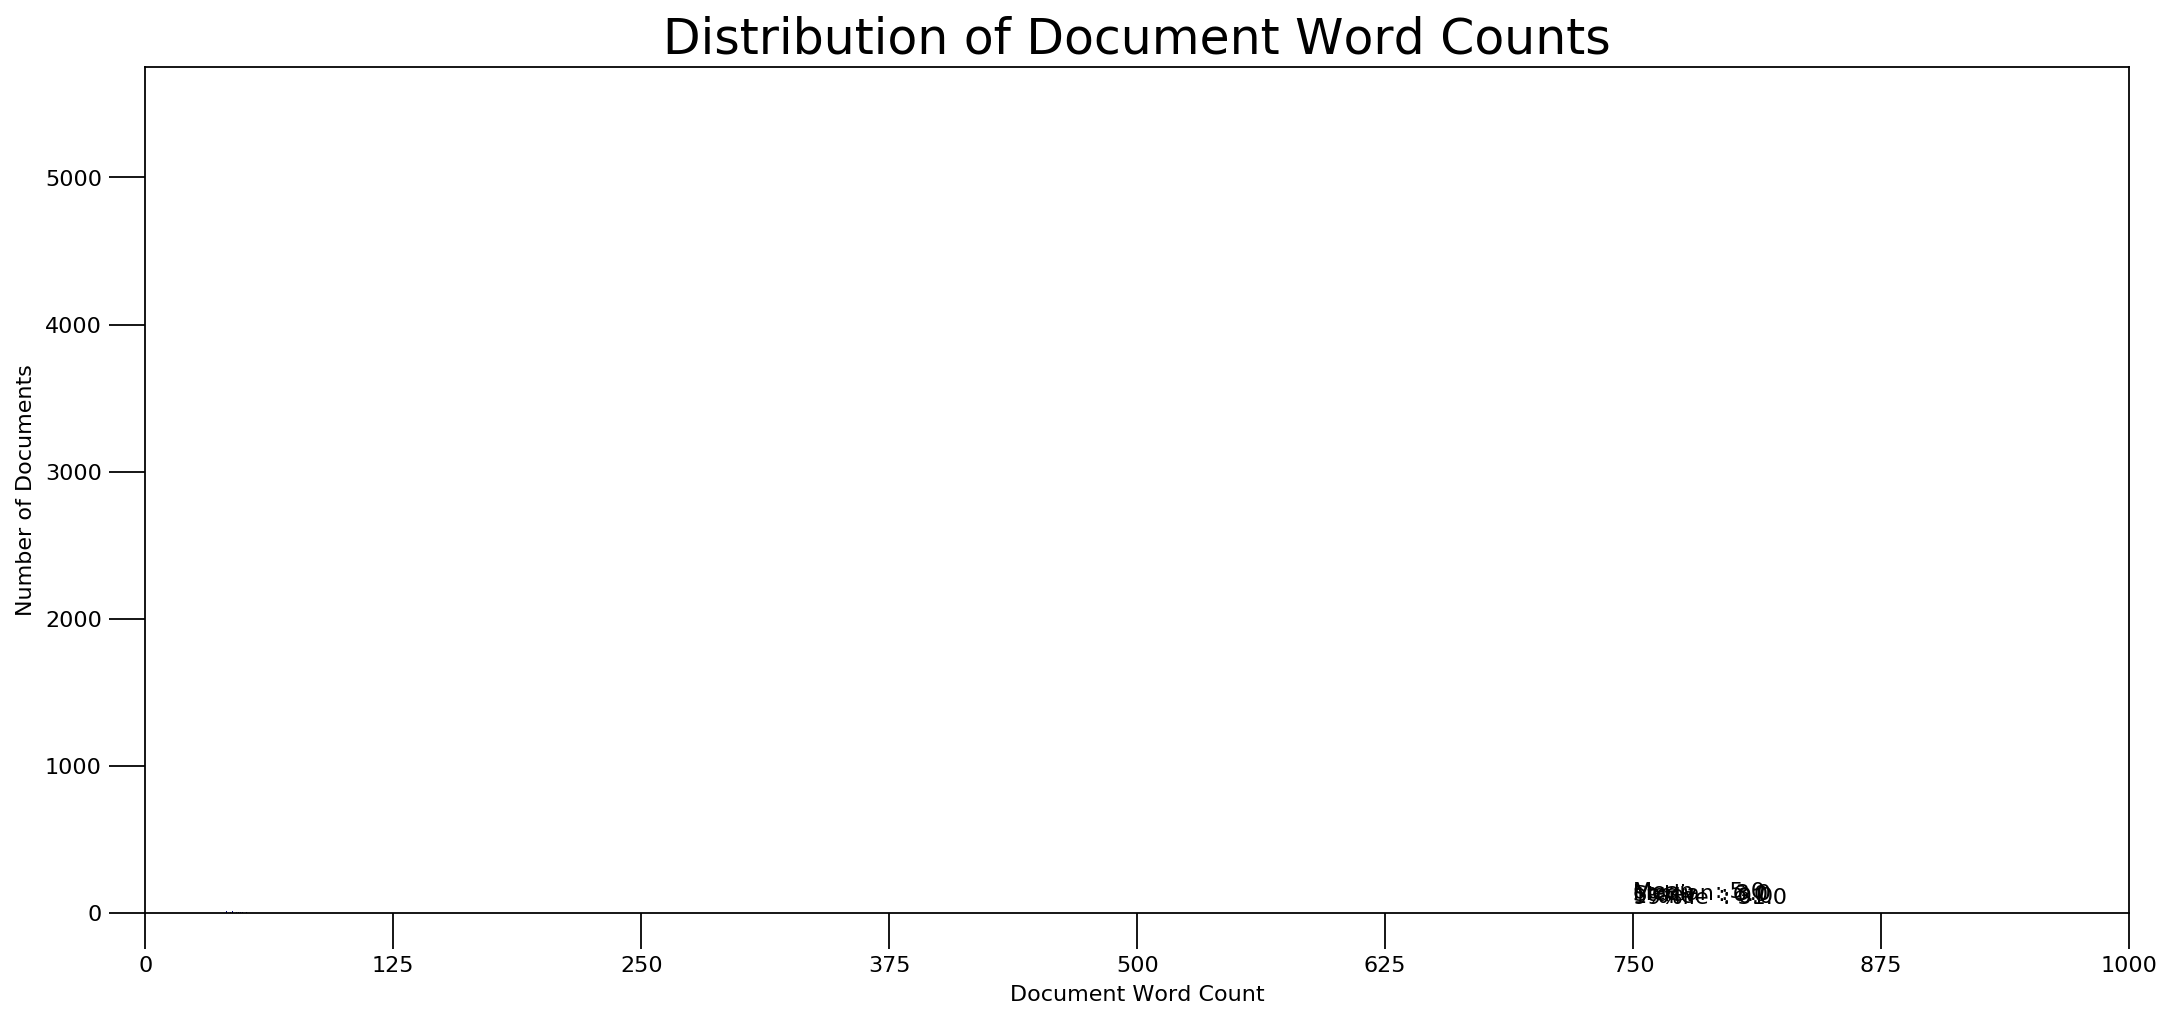

In [30]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

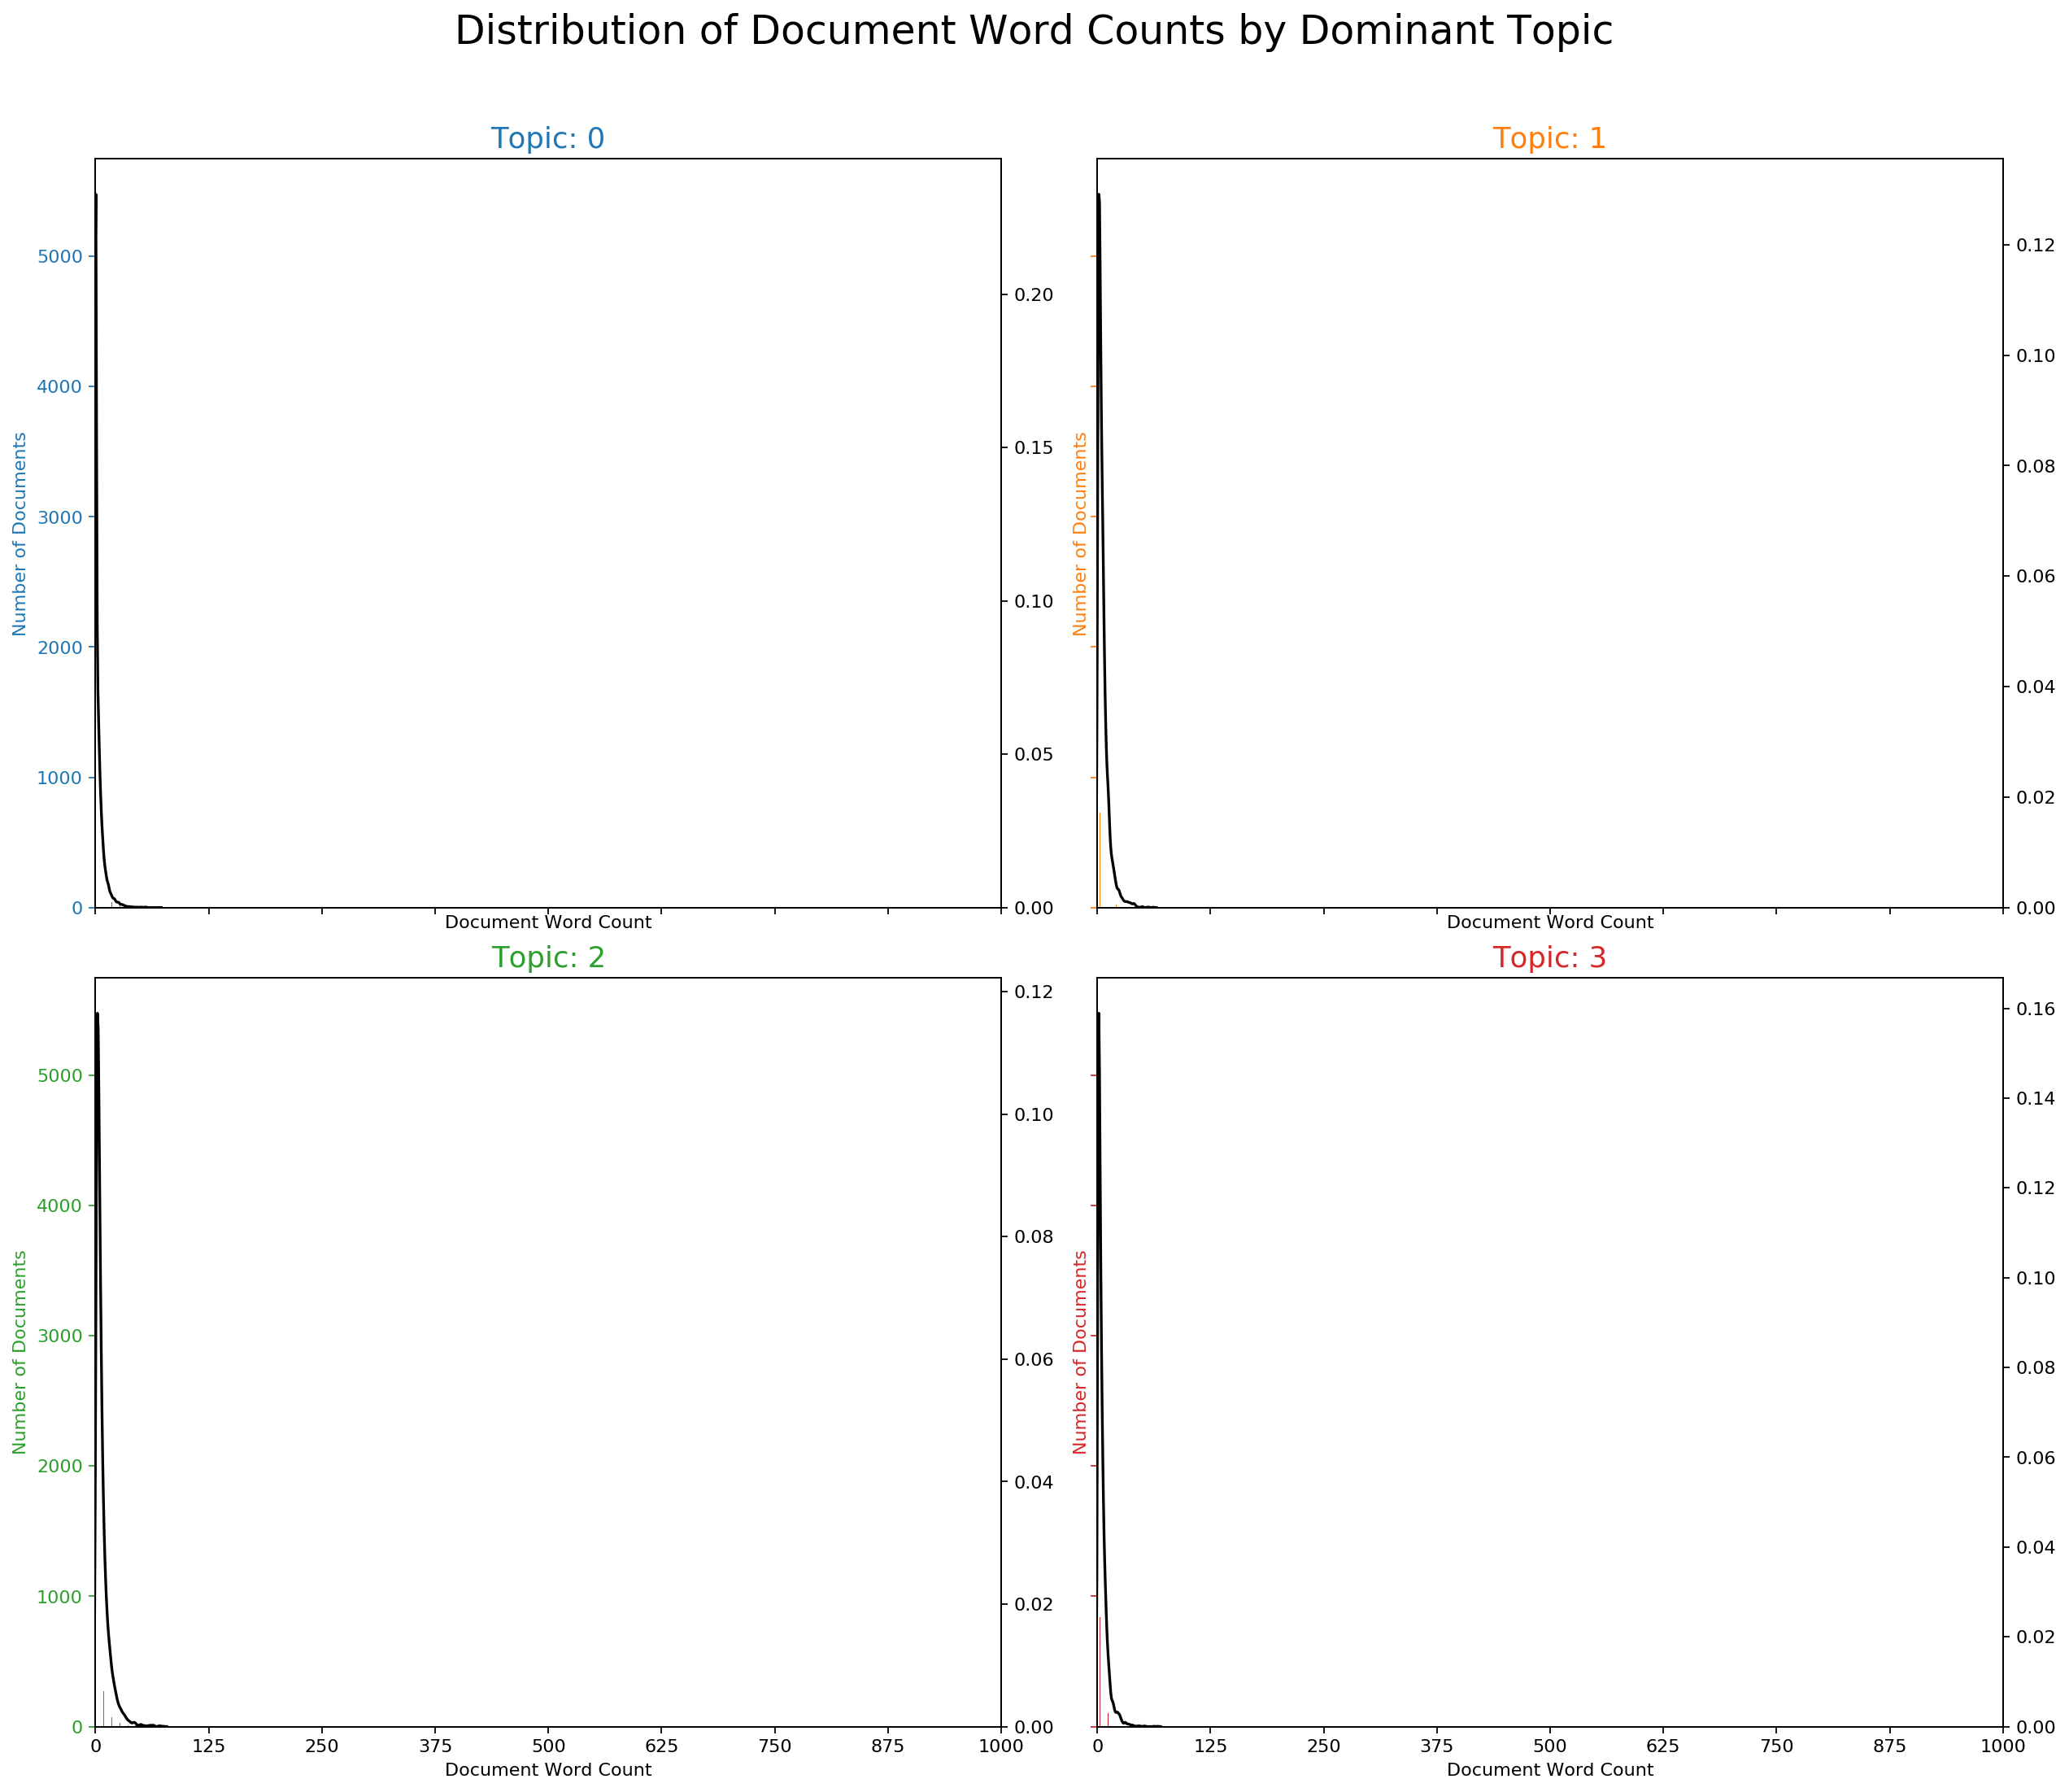

In [31]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

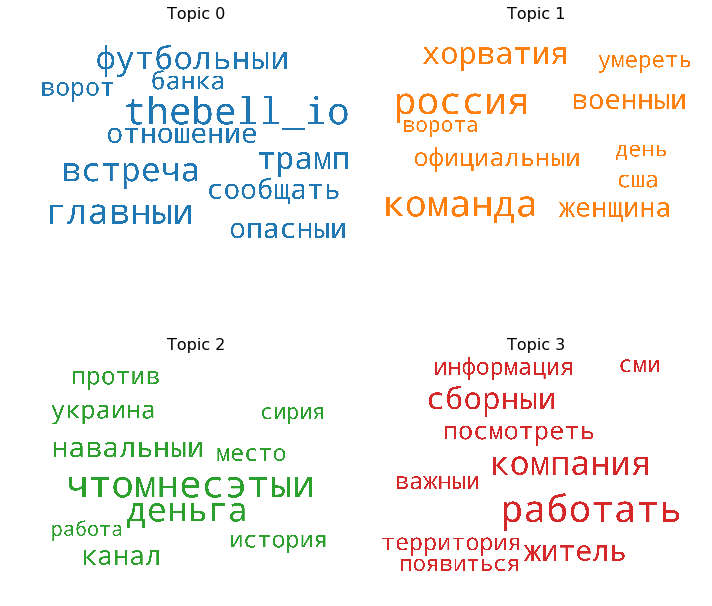

In [32]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()